In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score,roc_curve,mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as npline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("airbnb_cleaned_combined.csv")

# Display basic info
df.shape

(60380, 33)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60380 entries, 0 to 60379
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         60380 non-null  int64  
 1   host_id                    60380 non-null  int64  
 2   host_name                  60380 non-null  object 
 3   host_since                 60380 non-null  object 
 4   host_response_rate         60380 non-null  int64  
 5   host_listings_count        60380 non-null  int64  
 6   host_total_listings_count  60380 non-null  int64  
 7   city                       60380 non-null  object 
 8   state                      60380 non-null  object 
 9   zipcode                    60380 non-null  object 
 10  country                    60380 non-null  object 
 11  property_type              60380 non-null  object 
 12  room_type                  60380 non-null  object 
 13  accommodates               60380 non-null  int

In [104]:
df.columns

Index(['id', 'host_id', 'host_name', 'host_since', 'host_response_rate',
       'host_listings_count', 'host_total_listings_count', 'city', 'state',
       'zipcode', 'country', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'cancellation_policy',
       'reviews_per_month', 'zipcode_clean'],
      dtype='object')

In [106]:
df['host_response_rate'].unique()

array([100,  95,  85,  97,  67,  90,  50,  40,  88,   0,  94,  80,  83,
        33,  36,  75,  98,  71,  96,  89,  92,  78,  60,  99,  43,  93,
        68,  70,  63,  86,  66,  87,  91,  73,  10,  82,  57,  77,  17,
        58,  55,  44,  20,  84,  38,  30,  56,  79,  25,  27,  42,  74,
        59,  64,  69,  72,  76,  81,  61,  65,  46,  21,  31,  29,  62,
        41,  54,  23,  53,  18,  14,  11,  22,  37,  13,  47,  35,  52],
      dtype=int64)

# Focus Area 1. Listing and Host Performance Analysis

## Descriptive Analysis

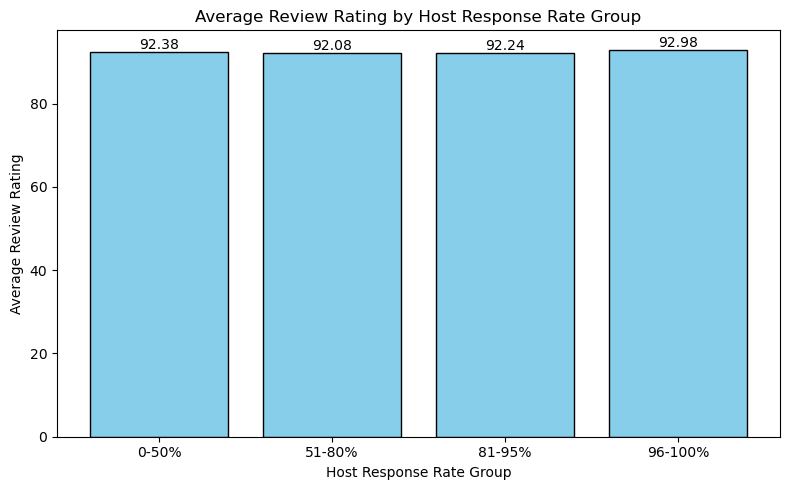

In [110]:
df_fa1 = df.copy()   
host_df = df_fa1[['host_response_rate', 'review_scores_rating','price']]

# Create response rate groups
bins = [0, 50, 80, 95, 100]
labels = ['0-50%', '51-80%', '81-95%', '96-100%']

host_df['response_group'] = pd.cut(host_df['host_response_rate'], bins=bins, labels= labels)
avg_ratings = host_df.groupby('response_group')['review_scores_rating'].mean().round(2)

#Bar Plot
plt.figure(figsize=(8,5))
bars = plt.bar(avg_ratings.index, avg_ratings.values, color='skyblue', edgecolor='black')
plt.bar_label(bars)
plt.title("Average Review Rating by Host Response Rate Group")
plt.xlabel("Host Response Rate Group")
plt.ylabel("Average Review Rating")
plt.tight_layout()
plt.show()

## Statistical Analysis

In [113]:
df_fa1['booking_flag'] = np.where(df_fa1['number_of_reviews'] > 0, 1, 0)
booked_prices = df_fa1[df_fa1['booking_flag'] == 1]['price']
not_booked_prices = df_fa1[df_fa1['booking_flag'] == 0]['price']

t_stat, p_val = stats.ttest_ind(booked_prices, not_booked_prices, equal_var=False)
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_val:.2f}")
alpha = 0.05
if p_val < alpha:
    print(" Reject H₀: Price significantly affects booking probability.")
else:
    print(" Accept H₀: No significant difference between groups.")


t-statistic: -10.16
p-value: 0.00
 Reject H₀: Price significantly affects booking probability.


## ML Model - LogisticRegression

In [118]:
# preprocessin
df_fa1["price_log"] = np.log1p(df_fa1["price"])
df_fa1["amenities"] = df_fa1["amenities"].astype(str)
df_fa1["amenities_count"] = df_fa1["amenities"].str.count(",") + 1

df_fa1["host_since"] = pd.to_datetime(df_fa1["host_since"], errors='coerce')
df_fa1["host_days"] = (pd.to_datetime("today") - df_fa1["host_since"]).dt.days

policy_map = {"flexible":1, "moderate":2, "strict":3}
df_fa1['cancellation_policy'] = df_fa1['cancellation_policy'].astype(str).str.lower()
df_fa1['cancellation_policy_enc'] = df_fa1['cancellation_policy'].map(policy_map).fillna(0)



Accuracy: 63.7 %
              precision    recall  f1-score   support

           0       0.37      0.71      0.49      2962
           1       0.87      0.61      0.72      9114

    accuracy                           0.64     12076
   macro avg       0.62      0.66      0.60     12076
weighted avg       0.75      0.64      0.66     12076

AUC Score: 0.715


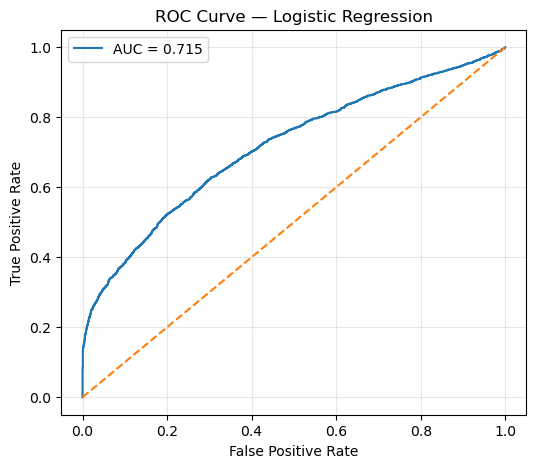

In [28]:
features = [
    "price_log","accommodates","bathrooms","bedrooms",
    "review_scores_rating","amenities_count","host_days",
    "minimum_nights","maximum_nights","cleaning_fee",
    "reviews_per_month","cancellation_policy_enc"
]

X = df_fa1[features].fillna(df_fa1[features].median())
y = df_fa1["booking_flag"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression(max_iter=1200, class_weight='balanced')
model.fit(X_train_s, y_train)

# Predictions
y_prob = model.predict_proba(X_test_s)[:, 1]
y_pred = model.predict(X_test_s)


print("\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print(classification_report(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", round(auc, 3))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Accuracy: 74.84 %
              precision    recall  f1-score   support

           0       0.33      0.02      0.05      2962
           1       0.76      0.98      0.86      9114

    accuracy                           0.75     12076
   macro avg       0.54      0.50      0.45     12076
weighted avg       0.65      0.75      0.66     12076

AUC Score: 0.715


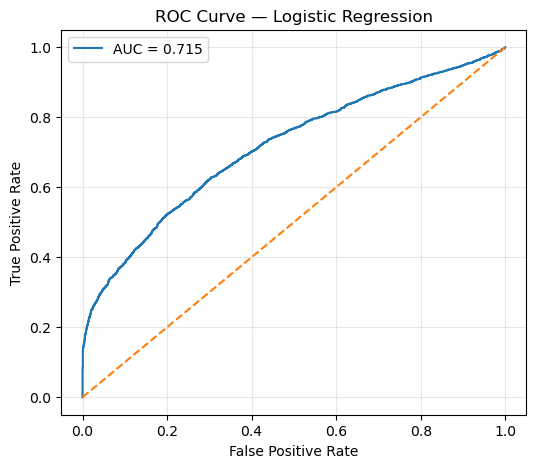

In [30]:
#ALTERNATIVE
features = [
    "price_log","accommodates","bathrooms","bedrooms",
    "review_scores_rating","amenities_count","host_days",
    "minimum_nights","maximum_nights","cleaning_fee",
    "reviews_per_month","cancellation_policy_enc"
]

X = df_fa1[features].fillna(df_fa1[features].median())
y = df_fa1["booking_flag"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression(max_iter=1200, class_weight='balanced')
model.fit(X_train_s, y_train)

# Predictions
y_prob = model.predict_proba(X_test_s)[:, 1]
best_threshold = 0.5
best_acc = 0

for t in [i/100 for i in range(20,80)]:   # try 0.20 to 0.79
    y_temp = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, y_temp)
    if acc > best_acc:
        best_acc = acc
        best_threshold = t

y_pred = (y_prob >= best_threshold).astype(int)


print("\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print(classification_report(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", round(auc, 3))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Focus Area 2: Guest Experience and Property Insight 

## Descriptive Analysis

In [34]:
df_fa2 = df.copy()
df_fa2["amenities"] = df_fa2["amenities"].astype(str)
df_fa2["amenities_count"] = df_fa2["amenities"].str.count(",") + 1
df_fa2["family_friendly"] = df_fa2["amenities"].str.contains("family|kid|children|crib|child|high chair", case=False).astype(int)
df_fa2["size"] = (df_fa2["accommodates"] + df_fa2["bathrooms"] + df_fa2["bedrooms"])


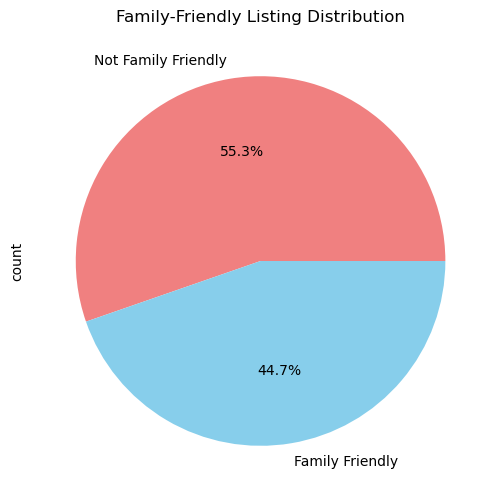

In [36]:
plt.figure(figsize=(6,6))
df_fa2["family_friendly"].value_counts().plot(kind="pie",labels=["Not Family Friendly", "Family Friendly"],autopct="%1.1f%%",colors=["lightcoral","skyblue"])
plt.title("Family-Friendly Listing Distribution")
plt.show()

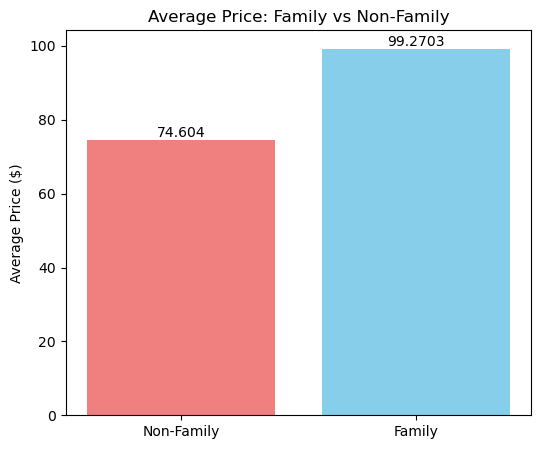

In [38]:
avg_prices = df_fa2.groupby("family_friendly")["price"].mean()
avg_prices.index = ["Non-Family", "Family"]

plt.figure(figsize=(6,5))
bars = plt.bar(avg_prices.index, avg_prices.values, color=["lightcoral","skyblue"])
plt.bar_label(bars)
plt.title("Average Price: Family vs Non-Family")
plt.ylabel("Average Price ($)")
plt.show()

## Statistical Analysis

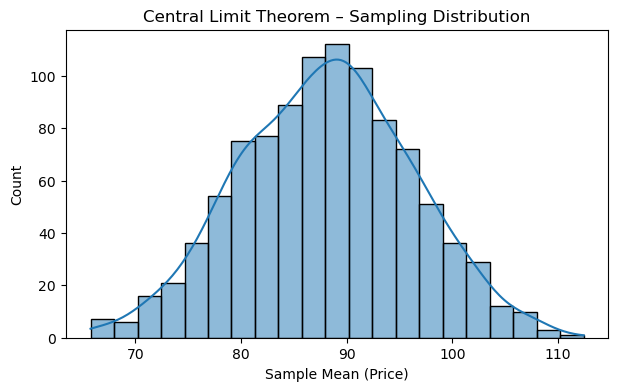

Sampling Mean: 88.08
Sampling Std: 8.15


In [41]:
sample_means = []

for i in range(1000):
    sample = df.price.sample(30, replace=True)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)
    
plt.figure(figsize=(7,4))
sns.histplot(sample_means, kde=True)
plt.title("Central Limit Theorem – Sampling Distribution")
plt.xlabel("Sample Mean (Price)")
plt.show()

print("Sampling Mean:", round(np.mean(sample_means), 2))
print("Sampling Std:", round(np.std(sample_means), 2))


## ML Model - K-means Clustering

In [44]:
X = df_fa2[["price", "size", "amenities_count"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_fa2.loc[X.index, "cluster"] = labels

centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns).sort_values("price")

# Map cluster names: Budget, Mid, Luxury
name_map = {centers_df.index[0]: "Budget",centers_df.index[1]: "Mid-Range",centers_df.index[2]: "Luxury"}
df_fa2["cluster_label"] = df_fa2["cluster"].map(name_map)

  File "C:\Users\ssham\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ssham\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ssham\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ssham\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


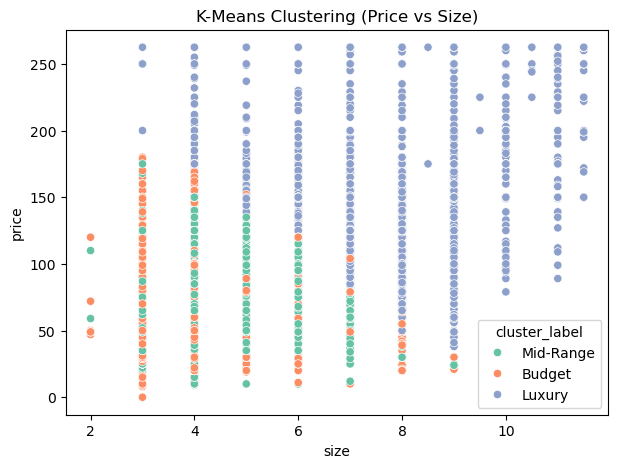

In [46]:
# Plot: Price vs Size
plt.figure(figsize=(7,5))
sns.scatterplot(x=X["size"], y=X["price"],hue=df_fa2.loc[X.index, "cluster_label"],palette="Set2")
plt.title("K-Means Clustering (Price vs Size)")
plt.show()

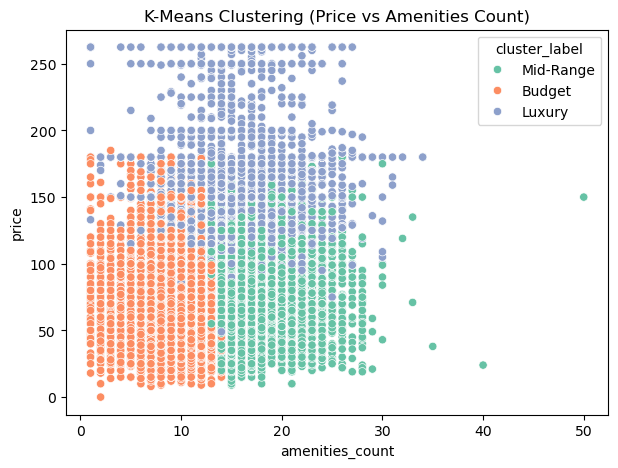

In [48]:
# Plot: Price vs Amenities Count
plt.figure(figsize=(7,5))
sns.scatterplot(x=X["amenities_count"], y=X["price"],hue=df_fa2.loc[X.index, "cluster_label"],palette="Set2")
plt.title("K-Means Clustering (Price vs Amenities Count)")
plt.show()

# Focus Area 3 : Location and Market Competitiveness

In [51]:
# data preprocessing
urban_cities = ["san francisco", "new york", "los angeles", "boston","chicago", "seattle", "washington", "austin"]

df["city_clean"] = df["city"].astype(str).str.lower()

df["area_type"] = np.where(df["city_clean"].isin(urban_cities),"Urban","Suburban")


## Statistical analysis

In [54]:
df_fa3 = df.copy()   

In [56]:
urban_prices = df_fa3[df_fa3["area_type"] == "Urban"]["price"]
suburban_prices = df_fa3[df_fa3["area_type"] == "Suburban"]["price"]

t_stat, p_val = stats.ttest_ind(urban_prices, suburban_prices, equal_var=False)

print("\n--- T-Test: Urban vs Suburban Prices ---")
print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

if p_val < 0.05:
    print("Reject H₀: Prices differ significantly between Urban and Suburban areas.")
else:
    print("Accept H₀: No significant difference found.")



--- T-Test: Urban vs Suburban Prices ---
t-statistic: 33.2058
p-value: 0.0
Reject H₀: Prices differ significantly between Urban and Suburban areas.


## ML Model - Logistic Regression


Accuracy: 74.2 %
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      7238
           1       0.70      0.61      0.66      4838

    accuracy                           0.74     12076
   macro avg       0.73      0.72      0.72     12076
weighted avg       0.74      0.74      0.74     12076



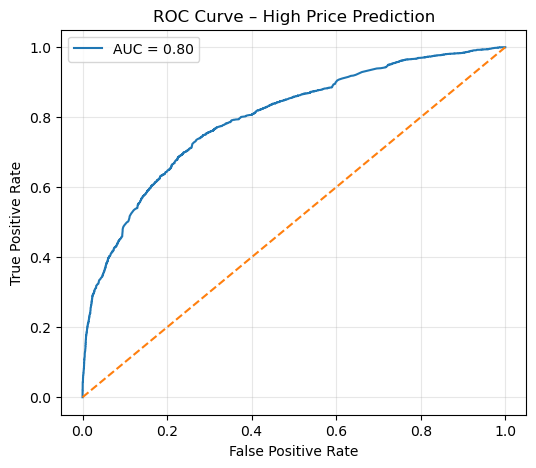

In [59]:
avg_price = df_fa3["price"].mean()
df_fa3["price_binary"] = (df_fa3["price"] > avg_price).astype(int)

# Encode categorical columns
for col in ["city", "state", "country", "property_type"]:
    df_fa3[col] = LabelEncoder().fit_transform(df_fa3[col].astype(str))

# Select features
X = df_fa3[["accommodates", "bathrooms", "bedrooms",
    "review_scores_rating", "number_of_reviews",
    "zipcode_clean", "city", "state", "country", "property_type"]].fillna(0)

y = df_fa3["price_binary"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

model = LogisticRegression(max_iter=800)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print(classification_report(y_test, y_pred))

# ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – High Price Prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Focus Area 4 : Demand and Policy Insights

## Descriptive Analysis

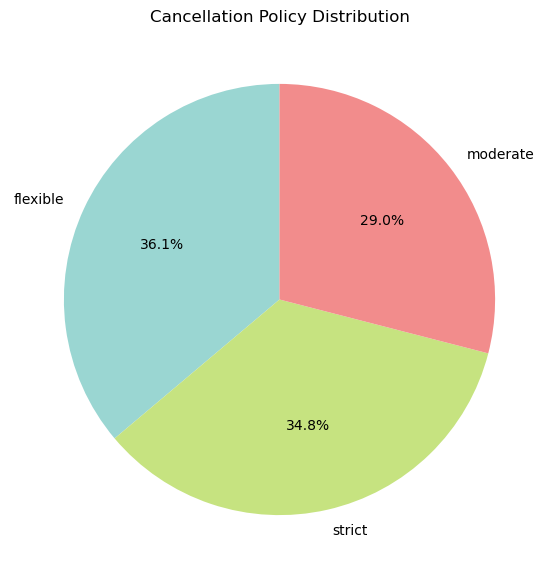

In [63]:
df_fa4 = df.copy()   
df4_main = df_fa4[df_fa4["cancellation_policy"].isin(["flexible", "moderate", "strict"])]

plt.figure(figsize=(7,7))
df4_main["cancellation_policy"].value_counts().plot(kind="pie",autopct="%1.1f%%",startangle=90,colors=["#9ad6d2", "#c6e380", "#f28c8c"])
plt.title("Cancellation Policy Distribution")
plt.ylabel("")
plt.show()

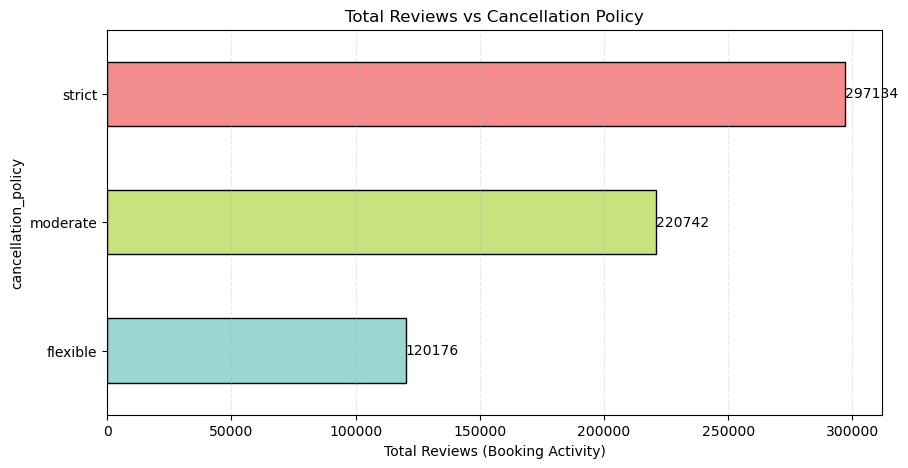

In [65]:
policy_reviews = df4_main.groupby("cancellation_policy")["number_of_reviews"].sum()

plt.figure(figsize=(10,5))
ax = policy_reviews.sort_values().plot(kind="barh",color=["#9ad6d2", "#c6e380", "#f28c8c"],edgecolor="black")
ax.bar_label(ax.containers[0])
plt.title("Total Reviews vs Cancellation Policy")
plt.xlabel("Total Reviews (Booking Activity)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.show()

## Statistical Analysis

In [68]:
flex = df4_main[df4_main["cancellation_policy"] == "flexible"]["review_scores_rating"]
strict = df4_main[df4_main["cancellation_policy"] == "strict"]["review_scores_rating"]

t_stat, p_val = stats.ttest_ind(flex, strict, equal_var=False)

print("\nT-Test: Flexible vs Strict Ratings")
print("t-stat:", round(t_stat, 4))
print("p-val:", round(p_val, 6))

if p_val < 0.05:
    print("Reject H₀: Ratings differ significantly between policies.")
else:
    print("Accept H₀: No significant difference in ratings.")


T-Test: Flexible vs Strict Ratings
t-stat: 2.5645
p-val: 0.010336
Reject H₀: Ratings differ significantly between policies.
